# Pectoral Removal Lab 2    

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from bcd.utils.image import grayscale

class DMImagePreprocessor(object):
    '''Class for preprocessing images in the DM challenge
    '''

    def __init__(self):
        '''Constructor for DMImagePreprocessor
        '''
        pass


    def select_largest_obj(self, img_bin, lab_val=255, fill_holes=False, 
                           smooth_boundary=False, kernel_size=15):
        '''Select the largest object from a binary image and optionally
        fill holes inside it and smooth its boundary.
        Args:
            img_bin (2D array): 2D numpy array of binary image.
            lab_val ([int]): integer value used for the label of the largest 
                    object. Default is 255.
            fill_holes ([boolean]): whether fill the holes inside the largest 
                    object or not. Default is false.
            smooth_boundary ([boolean]): whether smooth the boundary of the 
                    largest object using morphological opening or not. Default 
                    is false.
            kernel_size ([int]): the size of the kernel used for morphological 
                    operation. Default is 15.
        Returns:
            a binary image as a mask for the largest object.
        '''
        n_labels, img_labeled, lab_stats, _ = \
            cv2.connectedComponentsWithStats(img_bin, connectivity=8, 
                                             ltype=cv2.CV_32S)
        largest_obj_lab = np.argmax(lab_stats[1:, 4]) + 1
        largest_mask = np.zeros(img_bin.shape, dtype=np.uint8)
        largest_mask[img_labeled == largest_obj_lab] = lab_val
        # import pdb; pdb.set_trace()
        if fill_holes:
            bkg_locs = np.where(img_labeled == 0)
            bkg_seed = (bkg_locs[0][0], bkg_locs[1][0])
            img_floodfill = largest_mask.copy()
            h_, w_ = largest_mask.shape
            mask_ = np.zeros((h_ + 2, w_ + 2), dtype=np.uint8)
            cv2.floodFill(img_floodfill, mask_, seedPoint=bkg_seed, 
                          newVal=lab_val)
            holes_mask = cv2.bitwise_not(img_floodfill)  # mask of the holes.
            largest_mask = largest_mask + holes_mask
        if smooth_boundary:
            kernel_ = np.ones((kernel_size, kernel_size), dtype=np.uint8)
            largest_mask = cv2.morphologyEx(largest_mask, cv2.MORPH_OPEN, 
                                            kernel_)
            
        return largest_mask


    @staticmethod
    def max_pix_val(dtype):
        if dtype == np.dtype('uint8'):
            maxval = 2**8 - 1
        elif dtype == np.dtype('uint16'):
            maxval = 2**16 - 1
        else:
            raise Exception('Unknown dtype found in input image array')
        return maxval


    def suppress_artifacts(self, img, global_threshold=.05, fill_holes=False, 
                           smooth_boundary=True, kernel_size=15):
        '''Mask artifacts from an input image
        Artifacts refer to textual markings and other small objects that are 
        not related to the breast region.

        Args:
            img (2D array): input image as a numpy 2D array.
            global_threshold ([int]): a global threshold as a cutoff for low 
                    intensities for image binarization. Default is 18.
            kernel_size ([int]): kernel size for morphological operations. 
                    Default is 15.
        Returns:
            a tuple of (output_image, breast_mask). Both are 2D numpy arrays.
        '''
        maxval = self.max_pix_val(img.dtype)
        if global_threshold < 1.:
            low_th = int(img.max()*global_threshold)
        else:
            low_th = int(global_threshold)
        _, img_bin = cv2.threshold(img, low_th, maxval=maxval, 
                                   type=cv2.THRESH_BINARY)
        breast_mask = self.select_largest_obj(img_bin, lab_val=maxval, 
                                              fill_holes=True, 
                                              smooth_boundary=True, 
                                              kernel_size=kernel_size)
        img_suppr = cv2.bitwise_and(img, breast_mask)

        return (img_suppr, breast_mask)


    @classmethod
    def segment_breast(cls, img, low_int_threshold=.05, crop=True):
        '''Perform breast segmentation
        Args:
            low_int_threshold([float or int]): Low intensity threshold to 
                    filter out background. It can be a fraction of the max 
                    intensity value or an integer intensity value.
            crop ([bool]): Whether or not to crop the image.
        Returns:
            An image of the segmented breast.
        NOTES: the low_int_threshold is applied to an image of dtype 'uint8',
            which has a max value of 255.
        '''
        # Create img for thresholding and contours.
        img_8u = (img.astype('float32')/img.max()*255).astype('uint8')
        if low_int_threshold < 1.:
            low_th = int(img_8u.max()*low_int_threshold)
        else:
            low_th = int(low_int_threshold)
        _, img_bin = cv2.threshold(
            img_8u, low_th, maxval=255, type=cv2.THRESH_BINARY)
        ver = (cv2.__version__).split('.')
        if int(ver[0]) < 3:
            contours,_ = cv2.findContours(
                img_bin.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        else:
            _,contours,_ = cv2.findContours(
                img_bin.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cont_areas = [ cv2.contourArea(cont) for cont in contours ]
        idx = np.argmax(cont_areas)  # find the largest contour, i.e. breast.
        breast_mask = cv2.drawContours(
            np.zeros_like(img_bin), contours, idx, 255, -1)  # fill the contour.
        # segment the breast.
        img_breast_only = cv2.bitwise_and(img, img, mask=breast_mask)
        x,y,w,h = cv2.boundingRect(contours[idx])
        if crop:
            img_breast_only = img_breast_only[y:y+h, x:x+w]
        return img_breast_only, (x,y,w,h)

    
    def remove_pectoral(self, img, breast_mask, high_int_threshold=.9, 
                        morph_kn_size=3, n_morph_op=7, sm_kn_size=25):
        '''Remove the pectoral muscle region from an input image

        Args:
            img (2D array): input image as a numpy 2D array.
            breast_mask (2D array):
            high_int_threshold ([int]): a global threshold for high intensity 
                    regions such as the pectoral muscle. Default is 200.
            morph_kn_size ([int]): kernel size for morphological operations 
                    such as erosions and dilations. Default is 3.
            n_morph_op ([int]): number of morphological operations. Default is 7.
            sm_kn_size ([int]): kernel size for final smoothing (i.e. opening). 
                    Default is 25.
        Returns:
            an output image with pectoral muscle region removed as a numpy 
            2D array.
        Notes: this has not been tested on .dcm files yet. It may not work!!!
        '''
        # Enhance contrast and then thresholding.
        img_equ = cv2.equalizeHist(img)
        if high_int_threshold < 1.:
            high_th = int(img.max()*high_int_threshold)
        else:
            high_th = int(high_int_threshold)
        maxval = self.max_pix_val(img.dtype)
        _, img_bin = cv2.threshold(img_equ, high_th, 
                                   maxval=maxval, type=cv2.THRESH_BINARY)
        pect_marker_img = np.zeros(img_bin.shape, dtype=np.int32)
        # Sure foreground (shall be pectoral).
        pect_mask_init = self.select_largest_obj(img_bin, lab_val=maxval, 
                                                 fill_holes=True, 
                                                 smooth_boundary=False)
        kernel_ = np.ones((morph_kn_size, morph_kn_size), dtype=np.uint8)
        pect_mask_eroded = cv2.erode(pect_mask_init, kernel_, 
                                     iterations=n_morph_op)
        pect_marker_img[pect_mask_eroded > 0] = 255
        # Sure background - breast.
        pect_mask_dilated = cv2.dilate(pect_mask_init, kernel_, 
                                       iterations=n_morph_op)
        pect_marker_img[pect_mask_dilated == 0] = 128
        # Sure background - pure background.
        pect_marker_img[breast_mask == 0] = 64
        # Watershed segmentation.
        img_equ_3c = cv2.cvtColor(img_equ, cv2.COLOR_GRAY2BGR)
        cv2.watershed(img_equ_3c, pect_marker_img)
        img_equ_3c[pect_marker_img == -1] = (0, 0, 255)
        # Extract only the breast and smooth.
        breast_only_mask = pect_marker_img.copy()
        breast_only_mask[breast_only_mask == -1] = 0
        breast_only_mask = breast_only_mask.astype(np.uint8)
        breast_only_mask[breast_only_mask != 128] = 0
        breast_only_mask[breast_only_mask == 128] = 255
        kernel_ = np.ones((sm_kn_size, sm_kn_size), dtype=np.uint8)
        breast_only_mask = cv2.morphologyEx(breast_only_mask, cv2.MORPH_OPEN, 
                                            kernel_)
        img_breast_only = cv2.bitwise_and(img_equ, breast_only_mask)

        return (img_breast_only, img_equ_3c)


    def process(self, img, median_filtering=True, blur_kn_size=3, 
                artif_suppression=True, low_int_threshold=.05, kernel_size=15,
                pect_removal=False, high_int_threshold=.8, **pect_kwargs):
        '''Perform multi-stage preprocessing on the input image
        Args:
            blur_kn_size ([int]): kernel size for median blurring.
            low_int_threshold ([int]): cutoff used in artifacts suppression.
            high_int_threshold ([int]): cutoff used in pectoral muscle removal.
        Returns:
            a tuple of (processed_image, color_image_with_boundary). If 
            pectoral removal was not called, the color image is None.
        '''
        img_proc = img.copy()
        if median_filtering:
            img_proc = cv2.medianBlur(img_proc, blur_kn_size)
        if artif_suppression:
            img_proc, mask_ = self.suppress_artifacts(
                img_proc, global_threshold=low_int_threshold, 
                kernel_size=kernel_size)
        else:
            _, mask_ = self.suppress_artifacts(img_proc)
        if pect_removal:
            img_proc, img_col = self.remove_pectoral(
                img_proc, mask_, high_int_threshold=high_int_threshold, 
                **pect_kwargs)
        else:
            img_col = None

        return (img_proc, img_col)

In [2]:
FILEPATH = "data/image/1_dev/converted/train/malignant/7dcc12fd-88f0-4048-a6ab-5dd0bd836f08.png"

(4632, 3152)

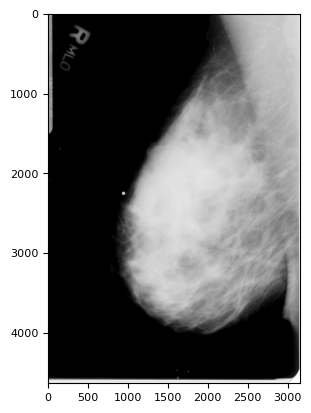

In [3]:
img = cv2.imread(FILEPATH)
plt.imshow(img)
img = img[:,:,0].squeeze()
img.shape

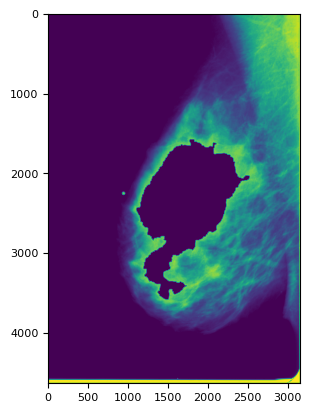

In [4]:
p = DMImagePreprocessor()
img2, img2_col = p.process(img, pect_removal=True)
plt.imshow(img2)